In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os, sys, warnings
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

# custom modules
from utilities import *
from helpers import *
# ---------------------------------------------------------
%matplotlib inline
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')
# ---------------------------------------------------------
# directories
main_dir = '../'
game_dir = main_dir+'data/'
Data = LoadData(main_dir, game_dir)

#### Load raw event data

In [2]:
# %%time
game_id = '0021500463'
game_data = Data.load_game(game_id)
events_df = pd.DataFrame(game_data['events'])
print('raw events shape:', events_df.shape)
events_df.head(2)

raw events shape: (231, 8)


,end_time_left,home,moments,orig_events,playbyplay,quarter,start_time_left,visitor
0,702.31,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351428029, 708.28, 12.78, None, [[-1,...",[0],GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,708.28,"{'abbreviation': 'TOR', 'players': [{'playerid..."
1,686.28,"{'abbreviation': 'CHI', 'players': [{'playerid...","[[1, 1451351428029, 708.28, 12.78, None, [[-1,...",[1],GAME_ID EVENTNUM EVENTMSGTYPE EVENTMS...,1,708.28,"{'abbreviation': 'TOR', 'players': [{'playerid..."


#### Load some meta info

In [3]:
# identify defending and offending runs (this is included in process_moments)
court_index = Data.load_csv('./meta_data/court_index.csv')
court_index = dict(zip(court_index.game_id, court_index.court_position))

# home and visitor ids
homeid = events_df.loc[0].home['teamid']
awayid = events_df.loc[0].visitor['teamid']

In [87]:
single_game[0].shape

(38, 20)

#### Pre-process 
filter events, subsample frames, add velocity, reorder moments, re-arrange team order
shot clock, filter out event with short moments

In [4]:
# filter out actions except 1: Make, 2: Miss, 4: Rebound, 6:Personal Foul, 7:Violation
use_event = [1, 2, 4, 6, 7]
discard_event = [3, 5, 8, 9, 10, 12, 13, 18]
events = filter_event_type(events_df, discard_event)
print('After filtering events has shape:', events.shape)
# break up sequences at 24secs shot clock point (or irregular case, e.g. out of bound maybe),
# and obtain the game data
subsample_factor = 0
single_game = get_game_data_ra(events, court_index, game_id, event_threshold=10, subsample_factor=subsample_factor)
print('Final number of events:', len(single_game))

After filtering events has shape: (134, 8)
Final number of events: 165


#### Prepare data set for training HMM

In [5]:
n_defend = 5
n_offend = 5
# length for each moment
event_lengths = np.array([len(i) for i in single_game])
# repeat the event_lengths 5 times in order to match the unstack later on with moments
event_lengths_repeat = np.concatenate([event_lengths for _ in range(n_defend)], axis=0)
# all the moments
all_moments = np.concatenate(single_game, axis=0)
# we only need the first 5 players x,y coordindates
all_defend_moments = all_moments[:, :2*n_defend]
all_offend_moments = all_moments[:, 2*n_offend:]

all_defend_moments_ = np.concatenate([all_defend_moments[:, i:i+2] for i in range(0, 2*n_defend, 2)], axis=0)
all_offend_moments_ = np.concatenate([all_offend_moments[:, i:i+2] for i in range(0, 2*n_offend, 2)], axis=0)

In [6]:
all_defend_moments_[:2]

array([[11.15334, 21.35529],
       [10.99227, 21.31452]])

In [7]:
all_offend_moments_[:2]

array([[24.18381, 44.21187],
       [24.25942, 44.12444]])

#### Create HMM model

In [8]:
n_comp = 7
n_mix = None
RA = RoleAssignment()

In [9]:
defend_state_sequence_, defend_means, defend_covs = RA.train_hmm(all_defend_moments_, event_lengths_repeat, n_comp, n_mix)
offend_state_sequence_, offend_means, offend_covs= RA.train_hmm(all_offend_moments_, event_lengths_repeat, n_comp, n_mix)

         1     -764370.3961             +nan
         2     -703428.7350      +60941.6612
         3     -647795.5585      +55633.1764
         4     -599464.6666      +48330.8920
         5     -562236.4580      +37228.2086
         6     -555454.4287       +6782.0293
         7     -554573.3004        +881.1283
         8     -554181.8134        +391.4870
         9     -553973.5739        +208.2396
        10     -553882.9054         +90.6685
        11     -553830.5544         +52.3510
        12     -553783.8820         +46.6724
        13     -553745.6227         +38.2593
        14     -553725.2137         +20.4089
        15     -553717.3051          +7.9087
        16     -553714.4519          +2.8532
        17     -553713.2756          +1.1763
        18     -553712.6772          +0.5984
        19     -553712.2790          +0.3983
        20     -553711.9353          +0.3436
        21     -553711.5942          +0.3412
        22     -553711.2710          +0.3231
        23

In [17]:
_, defend_roles = RA.assign_roles(all_defend_moments_, all_defend_moments, defend_means, event_lengths)
_, offend_roles = RA.assign_roles(all_offend_moments_, all_offend_moments, offend_means, event_lengths)

In [18]:
defend_roles[0].shape

(38, 5)

In [20]:
all_defend_moments_.shape

(105595, 2)

In [25]:
single_game[0].shape

(38, 20)

In [27]:
defend_roles[0].shape

(38, 5)

In [40]:
# defend_roles[0]

In [30]:
single_game[0][0]

array([11.15334, 21.35529, 16.79035, 20.55978,  9.12233, 39.32051,
       21.15543, 32.71616,  8.40459, 11.67492, 24.18381, 44.21187,
        1.06327,  2.54971,  7.28146, 48.40417, 18.1243 , 14.25539,
       10.82794, 26.70275])

In [34]:
single_game[0][0][list(defend_roles[0][0])]

array([21.35529, 16.79035, 21.15543, 20.55978,  9.12233])

In [58]:
def unstack_role(role, n=5):
    '''map the given role to the 10 index i.e. 5 players times 2 x,y coordinates
    '''
    repeats = np.repeat(role*2, [2]*n, axis=1).copy() # 2 for x,y coordinates
    repeats[:, range(1, 2*n, 2)] += 1
    return repeats


droles = [unstack_role(i, n_defend) for i in defend_roles]

# a = np.repeat(defend_roles[0]*2, [2]*n_defend, axis=1).copy() # 2 for x,y coordinates
# a[:, range(1, 2*n_defend, 2)] += 1
# a

In [63]:
a = np.zeros(14)
a

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [65]:
droles[0][0]

array([ 2,  3,  4,  5, 12, 13,  6,  7,  8,  9], dtype=int64)

In [74]:
ro_single_game = []
for i in range(len(single_game)):
    ro_i = []
    for j in range(len(single_game[i])):
        slots = np.zeros(2*n_comp)
        for k, v in enumerate(droles[i][j]):
            slots[v] = single_game[i][j][k]
        ro_i.append(slots)
    ro_single_game.append(np.array(ro_i))

In [75]:
len(ro_single_game)

165

In [76]:
ro_single_game[0].shape

(38, 14)

In [81]:
single_game[0][0].shape

(20,)

In [72]:
defend_roles[0][0]

array([1, 2, 6, 3, 4], dtype=int64)

In [80]:
order_moment_ra(single_game, defend_roles)[0][0]

array([ 0.     ,  0.     , 11.15334, 21.35529, 16.79035, 20.55978,
       21.15543, 32.71616,  8.40459, 11.67492,  0.     ,  0.     ,
        9.12233, 39.32051])

In [84]:
[i[:, 10] for i in single_game][0].shape

(38,)

In [85]:
order_moment_ra([i[:, :10] for i in single_game], defend_roles)[0][0]

array([ 0.     ,  0.     , 11.15334, 21.35529, 16.79035, 20.55978,
       21.15543, 32.71616,  8.40459, 11.67492,  0.     ,  0.     ,
        9.12233, 39.32051])

In [86]:
order_moment_ra([i[:, 10:] for i in single_game], offend_roles)[0][0]

array([ 0.     ,  0.     , 10.82794, 26.70275,  0.     ,  0.     ,
        7.28146, 48.40417, 24.18381, 44.21187,  1.06327,  2.54971,
       18.1243 , 14.25539])

In [60]:
a = np.repeat(defend_roles[0]*2, [2]*n_defend, axis=1).copy() # 2 for x,y coordinates
a

array([[ 2,  2,  4,  4, 12, 12,  6,  6,  8,  8],
       [ 2,  2,  4,  4, 12, 12,  6,  6,  8,  8],
       [ 2,  2,  4,  4, 12, 12,  6,  6,  8,  8],
       [ 2,  2,  4,  4, 12, 12,  6,  6,  8,  8],
       [ 2,  2,  4,  4, 12, 12,  6,  6,  8,  8],
       [ 2,  2,  4,  4, 12, 12,  6,  6,  8,  8],
       [ 2,  2,  4,  4, 12, 12,  6,  6,  8,  8],
       [ 2,  2,  4,  4, 12, 12,  6,  6,  8,  8],
       [ 2,  2,  4,  4, 12, 12,  6,  6,  8,  8],
       [ 2,  2,  4,  4, 12, 12,  6,  6,  8,  8],
       [ 2,  2,  4,  4, 12, 12,  6,  6,  8,  8],
       [ 2,  2,  4,  4, 12, 12,  6,  6,  8,  8],
       [ 2,  2,  4,  4, 12, 12,  6,  6,  8,  8],
       [ 2,  2,  4,  4, 12, 12,  6,  6,  8,  8],
       [ 2,  2,  4,  4, 12, 12,  6,  6,  8,  8],
       [ 2,  2,  4,  4, 12, 12,  6,  6,  8,  8],
       [ 2,  2,  4,  4, 12, 12,  6,  6,  8,  8],
       [ 2,  2,  4,  4, 12, 12,  6,  6,  8,  8],
       [ 2,  2,  4,  4, 12, 12,  6,  6,  8,  8],
       [ 2,  2,  4,  4, 12, 12, 10, 10,  8,  8],
       [ 2,  2,  4, 

#### Vis

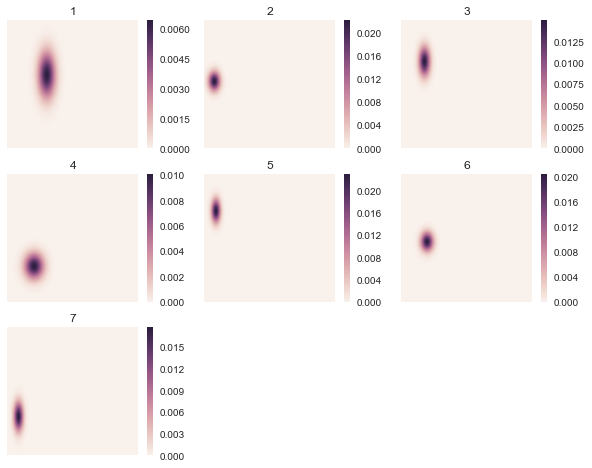

In [11]:
EmissionVis(n_comp, defend_means, defend_covs).plot()

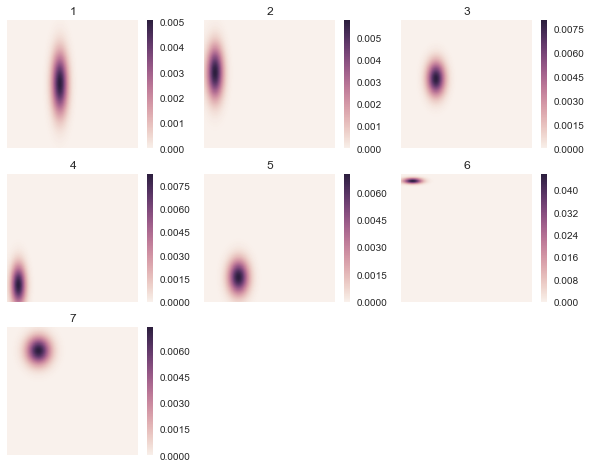

In [12]:
EmissionVis(n_comp, offend_means, offend_covs).plot()

---

### Next: try using the predefined position as indexing mechanism for the imitation learning

Questions:

  - Is the latent structure learning trained for each individual agent or their sequences are put together?